<a href="https://colab.research.google.com/github/vnvz/Titanic-ML-Analysis/blob/main/knn_eda_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports de libs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import shapiro

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
titanic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dados/titanic_train.csv')

Mounted at /content/drive


| Coluna          | Descrição                                           | Valores          | Tipo                                            |
| ------------- | --------------------------------------------------- | ---------------- | ------------------------------------------------ |
| Survival      | Sobrevivência do passageiro                        | 0 = Não, 1 = Sim | Dado qualitativo nominal                     |
| Pclass        | Classe do bilhete                                  | 1 = 1ª, 2 = 2ª, 3 = 3ª | Dado qualitativo ordinal  |
| Sex           | Sexo do passageiro                                 | Male, Female     | Dado qualitativo nominal                                                 |
| Age           | Idade do passageiro                                | Valor numérico   | Dado numérico           |
| SibSp         | Número de irmãos/cônjuges a bordo                  | Valor numérico   | Dado qualitativo nominal                   |
| Parch         | Número de pais/filhos a bordo                      | Valor numérico   | Dado qualitativo nominal                   |
| Ticket        | Número do bilhete                                  | Valor alfanumérico | Dado literal |
| Fare          | Tarifa paga pelo passageiro                        | Valor numérico   | Dado numérico        |
| Cabin         | Número da cabine                                   | Valor alfanumérico | Dado literal  |
| Embarked      | Porto de embarcação                                | C = Cherbourg, Q = Queenstown, S = Southampton | Dado qualitativo nominal      |
|PassengerId | Id do passageiro | Valor numérico | Valor quantitativo contínuo



In [ ]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#Preparação de dados I


##Remoção de colunas desnecessárias
- PassengerId: dado redundante quando podemos utilizar o número da linha para o mesmo fim.
- Name: por ser um dado em string que não importa muito no contexto.
- Cabin: muitos dados faltando e sem o auxílio de um mapa não é possível realizar uma interpretação muito a fundo.
- Ticket: dado em string difícil de interpretar.
- Fare: não planejamos analisar essa categoria mais a fundo devido a variações, então só vamos usar a variável `Pclass`.

In [ ]:
titanic = titanic.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Name', 'Fare'])
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


##Tratamento de valores nulos

Começaremos analisando a coluna Age, que pode possuir valores nulos que podem ser tratados.

In [ ]:
valores_nulos = titanic['Age'].isnull().sum()
print("Quantidade de valores nulos na coluna 'Age':", valores_nulos)

Quantidade de valores nulos na coluna 'Age': 177


Considerando esses valores e a possibilidade de substituir esses valores por outros adequados, podemos fazer uma distribuição dos valores para descobrir como agir a partir de então.

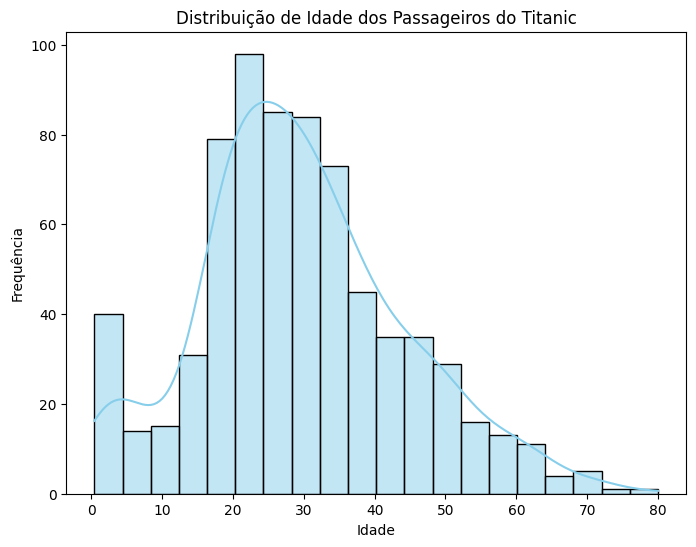

In [ ]:
plt.figure(figsize=(8, 6))

sns.histplot(data=titanic, x='Age', kde=True, bins=20, color='skyblue')

plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.title('Distribuição de Idade dos Passageiros do Titanic')
plt.show()

Vendo esses valores, podemos então substituir pela média das idades, já que a distribuição é aproximadamente simétrica.


In [ ]:
mean_age = titanic['Age'].mean()
titanic['Age'].fillna(mean_age, inplace=True)

Assim, podemos então remover os valores nulos.

In [ ]:
titanic.dropna(axis=0, inplace=True)

## Tratamento de valores categóricos
Temos aqui três colunas com valores categóricos:
- Sex: sexo do passageiro
- Embarked: qual porto ele embarcou (C = Cherbourg, Q = Queenstown, S = Southampton)

In [ ]:
titanic = pd.get_dummies(titanic, columns=['Sex'], prefix=['Sex'])
titanic = pd.get_dummies(titanic, columns=['Embarked'], prefix=['Embarked'])

## Remoção e criação de colunas
Podemos juntar as duas colunas `SibSp` e `Parch` em uma coluna só e chamá-la de `Accompanied`. Não há muito motivo para fazer essa distinção e isso simplifica o trabalho futuro.

In [ ]:
titanic['Accompanied'] = titanic['SibSp'] + titanic['Parch']
titanic = titanic.drop(columns=['SibSp', 'Parch'])

In [ ]:
titanic.head()

,Survived,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Accompanied
0,0,3,22.0,0,1,0,0,1,1
1,1,1,38.0,1,0,1,0,0,1
2,1,3,26.0,1,0,0,0,1,0
3,1,1,35.0,1,0,0,0,1,1
4,0,3,35.0,0,1,0,0,1,0


## Análise Exploratória dos Dados

In [ ]:
titanic.describe()

,Survived,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Accompanied
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.653446,0.350956,0.649044,0.188976,0.086614,0.724409,0.906637
std,0.486260,0.834700,12.968366,0.477538,0.477538,0.391710,0.281427,0.447063,1.614703
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,29.699118,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,3.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [ ]:
titanic.mode()

,Survived,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Accompanied
0,0,3,29.699118,0,1,0,0,1,0


## Heatmap
Após as análises básicas, será possível analisar correlações mais a fundo

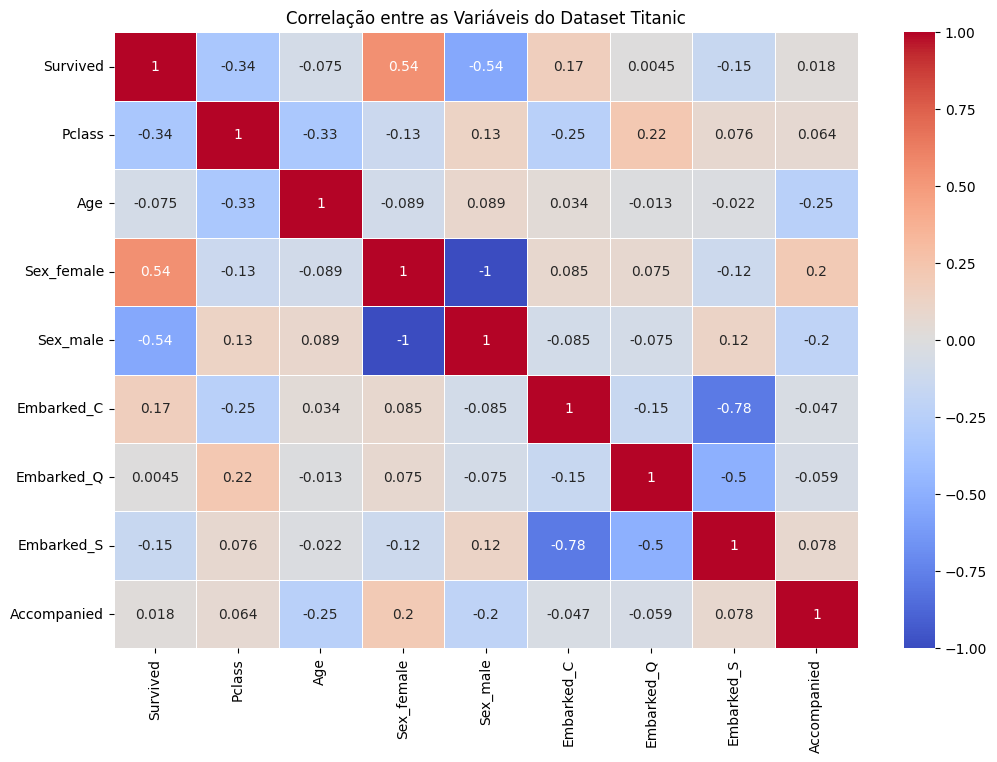

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(titanic.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlação entre as Variáveis do Dataset Titanic')
plt.show()

Portanto, podemos encontrar alguns valores interessantes quando relacionados a classe da passagem:
- `Pclass` e `Survived`: -0.34
- `Sex_female` e `Survived`: 0.54
- `Sex_male` e `Survived`: -0.54

Com isso, será interessante analisar a relação entre a sobrevivência dos passageiros de acordo com a classe da passagem e também a relação com o sexo dos passageiros.

## Sobrevivência dos passageiros de acordo com a Classe da Passagem
Isso será feito usando as colunas `Pclass` e `Survived`.

Primeiro, faremos um gráfico para mostrar a contagem de sobreviventes de acordo com a classe que eles embarcaram no navio. Logo, qual o percentual de passageiros que não sobreviveram de acordo com a classe da passagem?

<Figure size 800x600 with 0 Axes>

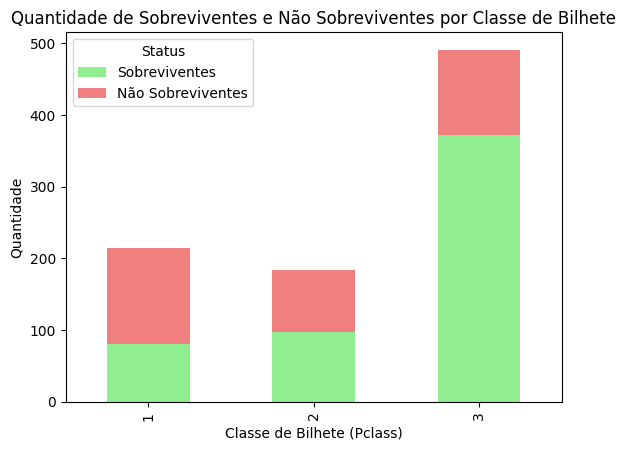

In [ ]:
survivors_by_class = titanic.groupby('Pclass')['Survived'].value_counts().unstack().fillna(0)

plt.figure(figsize=(8, 6))

survivors_by_class.plot(kind='bar', stacked=True, color=['lightgreen', 'lightcoral'])

plt.xlabel('Classe de Bilhete (Pclass)')
plt.ylabel('Quantidade')
plt.title('Quantidade de Sobreviventes e Não Sobreviventes por Classe de Bilhete')

plt.legend(['Sobreviventes', 'Não Sobreviventes'], title='Status', loc='upper left')
plt.show()

Através desse gráfico, podemos ver que a porcentagem de não sobreviventes na Classe 3 é definitivamente menor que a das outras classes, o que indica que houveram outros fatores que influenciaram na maior taxa de sobrevivência dos passageiros que compraram uma passagem da Classe 3.

##"Mulheres e crianças primeiro"
Esse código de conduta em tragédias normalmente é atribuído ao que ocorreu no Titanic. Podemos então comprovar essa afirmação analisando alguns dados.

## Sobrevivência do passageiro de acordo com o sexo dele
Usaremos as colunas `Sex_female`,`Sex_male` e `Survived`.

Através também de um gráfico de barras, podemos analisar a taxa de sobrevivência para determinar a influência do sexo do passageiro nas suas chances de sobrevivência na tragédia. Qual a quantidade de homens e mulheres que sobreviveram?


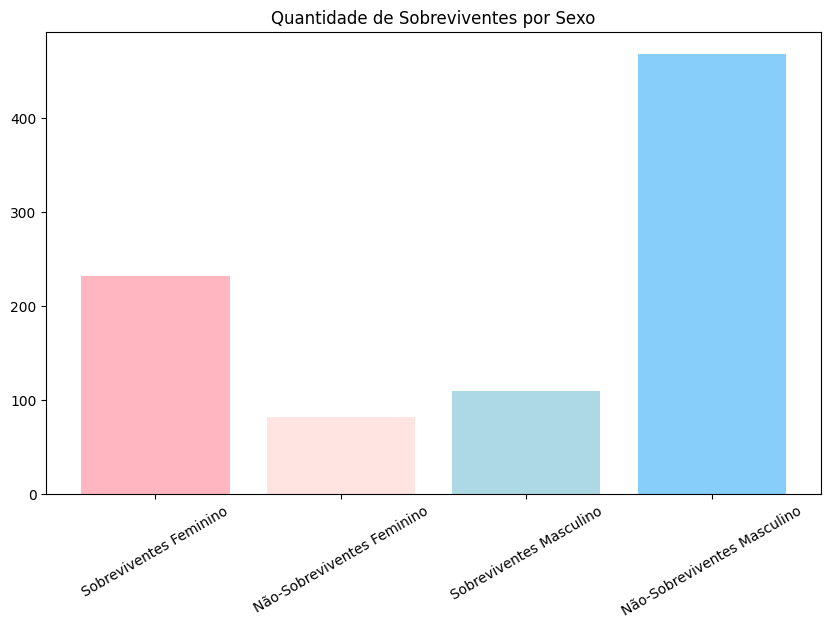

In [ ]:
female_survivors = titanic[titanic['Sex_female'] == 1]['Survived']

male_survivors = titanic[titanic['Sex_male'] == 1]['Survived']

female_survivors_count = female_survivors.sum()
female_non_survivors_count = female_survivors.size - female_survivors_count

male_survivors_count = male_survivors.sum()
male_non_survivors_count = male_survivors.size - male_survivors_count

categories = ['Sobreviventes Feminino', 'Não-Sobreviventes Feminino', 'Sobreviventes Masculino', 'Não-Sobreviventes Masculino']
counts = [female_survivors_count, female_non_survivors_count, male_survivors_count, male_non_survivors_count]
colors = ['lightpink', 'mistyrose', 'lightblue', 'lightskyblue']

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colors)
plt.title('Quantidade de Sobreviventes por Sexo')

plt.xticks(rotation=30)
plt.show()

Através da análise do gráfico acima, podemos afirmar que a maioria dos sobreviventes do Titanic foram mulheres. Possívelmente devido a procedimentos que priorizaram a evacuação delas em contrapartida aos homens.

## Sobrevivência do passageiro de acordo com a faixa etária
Também podemos analisar a sobrevivência do passageiro de acordo com sua faixa etária para determinarmos padrões nesse caso.

Para isso, teremos que discretizar a idade em três faixas definidas:
- Jovem: `< 18`
- Adulto: `Age >= 18 e Age < 60`
- Idoso: `Age >= 60`

In [ ]:
limites_categorias = [0, 18, 60, float('inf')]
rotulos_categorias = ['Jovem', 'Adulto', 'Idoso']

titanic['Age_range'] = pd.cut(titanic['Age'], bins=limites_categorias, labels=rotulos_categorias, right=False)
titanic.head()

,Survived,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Accompanied,Age_range
0,0,3,22.0,0,1,0,0,1,1,Adulto
1,1,1,38.0,1,0,1,0,0,1,Adulto
2,1,3,26.0,1,0,0,0,1,0,Adulto
3,1,1,35.0,1,0,0,0,1,1,Adulto
4,0,3,35.0,0,1,0,0,1,0,Adulto


Com essa nova categoria criada, podemos analisar a quantidade de sobreviventes de acordo com sua categoria.

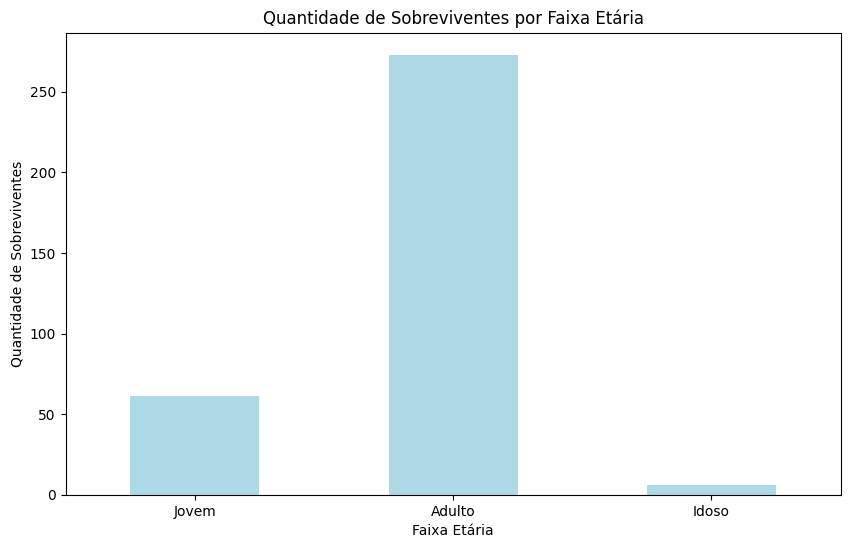

In [ ]:
faixa_etaria_counts = titanic.groupby('Age_range')['Survived'].sum()

plt.figure(figsize=(10, 6))
faixa_etaria_counts.plot(kind='bar', color='lightblue')

plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade de Sobreviventes')
plt.title('Quantidade de Sobreviventes por Faixa Etária')

plt.xticks(rotation=360)
plt.show()

Podemos então ver que uma quantidade grande de adultos comparados as outras categorias, mas se considerarmos o total de passageiros, esse é um valor esperado já que a maioria dos passageiros eram adultos, assim tendendo que a maior quantidade de sobreviventes também fosse pertencente a essa categoria.

## Conclusão
Por fim, podemos concluir que as evidências apontam que, considerando a quantidade de passageiros de cada faixa etária e sexo, a afirmação que o procedimento de "Mulheres e crianças primeiro" foi seguido é verdade. Porém com algumas nuâncias que podem ser encontradas na literatura:

Os capitães interpretaram a ordem de evacuação de maneiras diferentes: alguns interpretaram que eram apenas mulheres e crianças e outros que eram mulheres e crianças primeiro, resultando em evacuações um pouco desordenadas.

[Referência](https://www.anesi.com/titanic.htm)

#Preparação de dados II

Para seguirmos para a preparação de dados para os exercícios de aprendizado de máquina, precisamos realizar mais alguns tratamentos nos dados.

##Substituição de colunas literais por valores numéricos
Não precisamos mais da categoria de categorização de idade, portanto, vamos dropar ela e seguir usando age.

In [ ]:
titanic = titanic.drop(columns=['Age_range'])
titanic.head()

,Survived,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Accompanied
0,0,3,22.0,0,1,0,0,1,1
1,1,1,38.0,1,0,1,0,0,1
2,1,3,26.0,1,0,0,0,1,0
3,1,1,35.0,1,0,0,0,1,1
4,0,3,35.0,0,1,0,0,1,0


## Teste de Shapiro-Wilk
Iremos realizar o teste de Shapiro-Wilk para descobrirmos se é necessário normalizar os dados do dataset.

In [ ]:
for column in titanic.columns:
    stat, p = shapiro(titanic[column])
    alpha = 0.05

    if p > alpha:
        print(f'A variável "{column}" parece seguir uma distribuição normal (p-value={p:.4f})')
    else:
        print(f'A variável "{column}" não segue uma distribuição normal (p-value={p:.4f})')

A variável "Survived" não segue uma distribuição normal (p-value=0.0000)
A variável "Pclass" não segue uma distribuição normal (p-value=0.0000)
A variável "Age" não segue uma distribuição normal (p-value=0.0000)
A variável "Sex_female" não segue uma distribuição normal (p-value=0.0000)
A variável "Sex_male" não segue uma distribuição normal (p-value=0.0000)
A variável "Embarked_C" não segue uma distribuição normal (p-value=0.0000)
A variável "Embarked_Q" não segue uma distribuição normal (p-value=0.0000)
A variável "Embarked_S" não segue uma distribuição normal (p-value=0.0000)
A variável "Accompanied" não segue uma distribuição normal (p-value=0.0000)


Como podemos observar após o teste, nenhuma variável do dataset segue uma distribuição normal, portanto necessitam ser normalizadas para os testes seguintes.

##Normalização de dados
Primeiramente, utilizaremos PowerTransformer para normalização e em seguida o RobustScaler para organizar os dados.
Chegamos a conclusão que utilizar o PowerTransformer utilizando o método Yeo-Johnson era o mais adequado para realizar a normalização do dataset. Não utilizamos o método Box-Cox pois o dataset possuía valores negativos, enquanto o Yeo-Johnson permite o uso deles.

In [ ]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
titanic_normal = power_transformer.fit_transform(titanic)

scaler = RobustScaler()
titanic_scaled = scaler.fit(titanic_normal).transform(titanic_normal)

colunas = ['Survived', 'Pclass','Age', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Accompanied']
titanic_scaled = pd.DataFrame(titanic_scaled, columns=colunas)
titanic_scaled.head()

,Survived,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Accompanied
0,0.0,0.000000,-0.601663,0.0,0.0,0.000000,0.0,0.0,1.0
1,1.0,-1.590506,0.619071,1.0,-1.0,2.554345,0.0,-1.0,1.0
2,1.0,0.000000,-0.285229,1.0,-1.0,0.000000,0.0,0.0,0.0
3,1.0,-1.590506,0.398337,1.0,-1.0,0.000000,0.0,0.0,1.0
4,0.0,0.000000,0.398337,0.0,0.0,0.000000,0.0,0.0,0.0


## Divisão da base de dados para o método holdout
Separaremos a tabela em uma proporção 80/20 usando a classe survived como target.

In [ ]:
y = titanic_scaled['Survived']
X = titanic_scaled.drop('Survived', axis=1)

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

#k-NN (k-Nearest Neighbours)

### Implementação própria do k-NN
Primeiramente, vamos implementar uma função própria do classificador k-NN.

In [ ]:
def knn_classifier(train_data, test_data, train_labels, k):
    predictions = []

    for test_instance in test_data.values:
        distances = np.sqrt(np.sum((train_data.values - test_instance) ** 2, axis=1))
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = train_labels.iloc[nearest_indices]
        predicted_class = nearest_labels.value_counts().idxmax()

        predictions.append(predicted_class)

    return predictions

Após isso, vamos realizar as etapas de treinamento nos dados de treinamento e nos dados de teste, iniciamente definindo o valor de `k` arbitrariamente em 5.

In [ ]:
k = 5 # Valor definido em 5 arbitrariamente
predicoes_treinamento = knn_classifier(X_treinamento, X_treinamento, y_treinamento, k)
predicoes_teste = knn_classifier(X_treinamento, X_teste, y_treinamento, k)

Então, calcularemos a precisão do modelo, que utilizou `k = 5`, para descobrirmos a qualidade das predições.

In [ ]:
y_treinamento.head()
y_teste.head()

280    0.0
434    1.0
39     1.0
417    0.0
584    1.0
Name: Survived, dtype: float64

In [ ]:
acuracia_treinamento = accuracy_score(y_treinamento, predicoes_treinamento)
acuracia_teste = accuracy_score(y_teste, predicoes_teste)

print(f'Acurácia nos dados de treinamento: {acuracia_treinamento * 100:.2f}%')
print(f'Acurácia nos dados de teste: {acuracia_teste * 100:.2f}%')

Acurácia nos dados de treinamento: 85.51%
Acurácia nos dados de teste: 78.65%


Como podemos ver, os valores já foram relativamente altos, mas agora podemos rodar o mesmo código com valores diferentes de `k` e testar qual valor é o mais adequado para os testes. Para isso, utilizaremos um loop que armazenará os resultados correspondentes ao `k` utilizado.

In [ ]:
valores_k = [1, 3, 5, 7, 9]
resultados_acuracia_treinamento = []
resultados_acuracia_teste = []
valores_k_utilizados = []

for k in valores_k:
    predicoes_treinamento = knn_classifier(X_treinamento, X_treinamento, y_treinamento, k)
    predicoes_teste = knn_classifier(X_treinamento, X_teste, y_treinamento, k)

    acuracia_treinamento = accuracy_score(y_treinamento, predicoes_treinamento)
    acuracia_teste = accuracy_score(y_teste, predicoes_teste)

    resultados_acuracia_treinamento.append(acuracia_treinamento)
    resultados_acuracia_teste.append(acuracia_teste)
    valores_k_utilizados.append(k)


for i in range(len(valores_k_utilizados)):
    print(f'k = {valores_k_utilizados[i]},\nAcurácia nos dados de treinamento: {resultados_acuracia_treinamento[i] * 100:.2f}%, \nAcurácia nos dados de teste: {resultados_acuracia_teste[i] * 100:.2f}%')


k = 1,
Acurácia nos dados de treinamento: 92.55%, 
Acurácia nos dados de teste: 80.90%
k = 3,
Acurácia nos dados de treinamento: 87.34%, 
Acurácia nos dados de teste: 80.90%
k = 5,
Acurácia nos dados de treinamento: 85.51%, 
Acurácia nos dados de teste: 78.65%
k = 7,
Acurácia nos dados de treinamento: 83.83%, 
Acurácia nos dados de teste: 78.09%
k = 9,
Acurácia nos dados de treinamento: 83.40%, 
Acurácia nos dados de teste: 78.65%


Para melhor visualização, plotaremos um gráfico

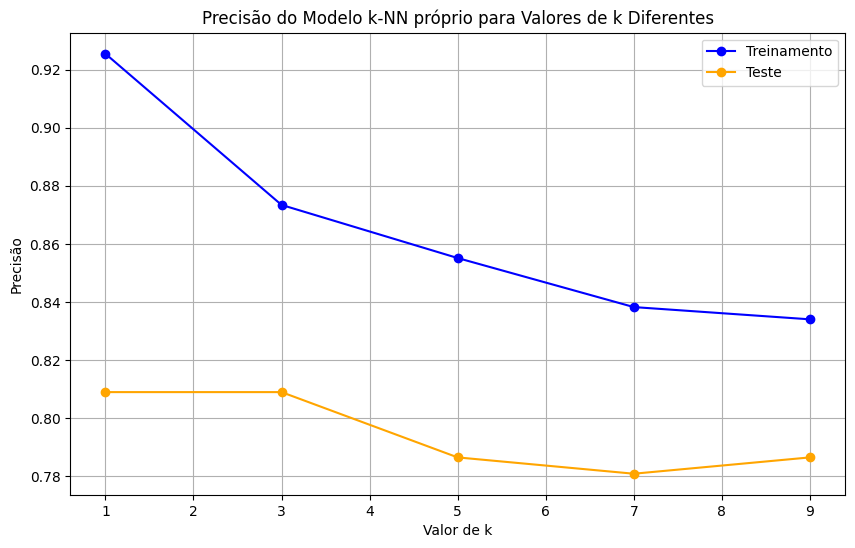

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(valores_k, resultados_acuracia_treinamento, marker='o', label='Treinamento', linestyle='-', color='blue')
plt.plot(valores_k, resultados_acuracia_teste, marker='o', label='Teste', linestyle='-', color='orange')

plt.xlabel('Valor de k')
plt.ylabel('Precisão')
plt.title('Precisão do Modelo k-NN próprio para Valores de k Diferentes')
plt.legend()

plt.grid(True)
plt.show()

Analisando o valor de `k` de cada teste, podemos inferir alguns pontos:
- `k = 1`: A precisão no treinamento é muito alta, e a de teste também é alta.
- `k = 3`: A precisão no treinamento diminuiu e a do valor de teste manteve-se o mesmo, o que indica que provavelmente o modelo está ajustando bem para os valores.
- `k = 5`: As precisões continuam a descer, o que indica que estamos próximos de um valor adequado.
- `k = 7`: O valor de precisão do treinamento segue abaixando e o do dado de teste também.
- `k = 11`: O valor de precisão do treinamento abaixou, assim como os de teste.

Portanto, baseando-se nessa análise, o melhor valor de `k` seria `k = 1`.

### Implementação KNeighborsClassifier do SKLearn
Agora, repetiremos todo esse processo utilizando a implementação da lib KNeighborsClassifier do SKLearn.

In [ ]:
k = 5 # Novamente, 5 definido arbitrariament
modelo_knn = KNeighborsClassifier(n_neighbors=k)
modelo_knn.fit(X_treinamento, y_treinamento)

KNeighborsClassifier()

In [ ]:
predicoes_treinamento_knc = modelo_knn.predict(X_treinamento)
predicoes_teste_knc = modelo_knn.predict(X_teste)

acuracia_treinamento_knc = accuracy_score(y_treinamento, predicoes_treinamento_knc)
acuracia_teste_knc = accuracy_score(y_teste, predicoes_teste_knc)

print(f'Acurácia nos dados de treinamento: {acuracia_treinamento_knc * 100:.2f}%')
print(f'Acurácia nos dados de teste: {acuracia_teste_knc * 100:.2f}%')

Acurácia nos dados de treinamento: 85.23%
Acurácia nos dados de teste: 78.09%


Agora, faremos um loop testando 5 valores diferentes de `k`.

In [ ]:
valores_k = [1, 3, 5, 7, 9]
resultados_acuracia_treinamento_knc = []
resultados_acuracia_teste_knc = []

for k in valores_k:
    modelo_knn = KNeighborsClassifier(n_neighbors=k)
    modelo_knn.fit(X_treinamento, y_treinamento)

    predicoes_treinamento = modelo_knn.predict(X_treinamento)
    predicoes_teste = modelo_knn.predict(X_teste)

    acuracia_treinamento_knc = accuracy_score(y_treinamento, predicoes_treinamento)
    acuracia_teste_knc = accuracy_score(y_teste, predicoes_teste)

    resultados_acuracia_treinamento_knc.append(acuracia_treinamento_knc)
    resultados_acuracia_teste_knc.append(acuracia_teste_knc)

for i in range(len(valores_k)):
    print(f'k = {valores_k[i]},\nAcurácia nos dados de treinamento: {resultados_acuracia_treinamento_knc[i] * 100:.2f}%, \nAcurácia nos dados de teste: {resultados_acuracia_teste_knc[i] * 100:.2f}%')
    print("\n")

k = 1,
Acurácia nos dados de treinamento: 93.25%, 
Acurácia nos dados de teste: 82.02%


k = 3,
Acurácia nos dados de treinamento: 86.50%, 
Acurácia nos dados de teste: 79.78%


k = 5,
Acurácia nos dados de treinamento: 85.23%, 
Acurácia nos dados de teste: 78.09%


k = 7,
Acurácia nos dados de treinamento: 83.54%, 
Acurácia nos dados de teste: 78.09%


k = 9,
Acurácia nos dados de treinamento: 83.12%, 
Acurácia nos dados de teste: 78.65%




Para melhor visualização, plotaremos um gráfico.

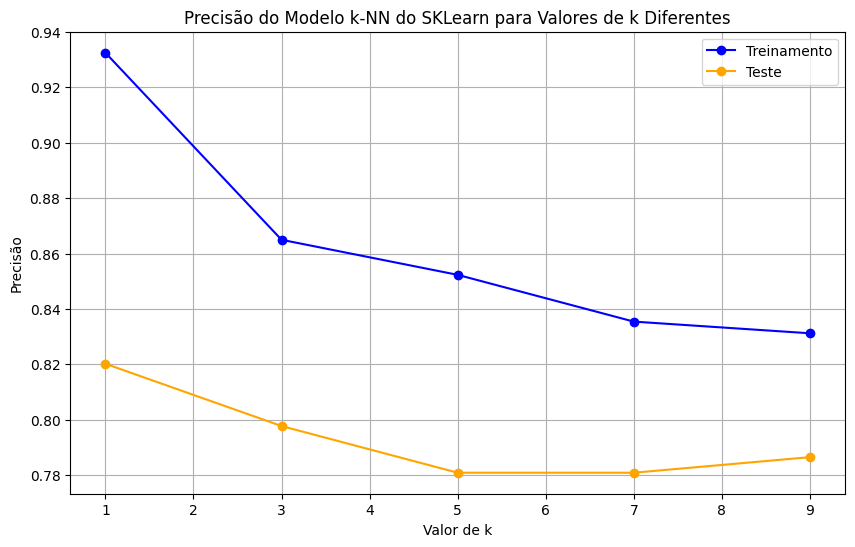

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(valores_k, resultados_acuracia_treinamento_knc, marker='o', label='Treinamento', linestyle='-', color='blue')
plt.plot(valores_k, resultados_acuracia_teste_knc, marker='o', label='Teste', linestyle='-', color='orange')

plt.xlabel('Valor de k')
plt.ylabel('Precisão')
plt.title('Precisão do Modelo k-NN do SKLearn para Valores de k Diferentes')
plt.legend()

plt.grid(True)
plt.show()

Analisando o valor de `k` de cada teste, podemos inferir o seguinte:
- `k = 1`: A precisão no treinamento é muito alta, assim como a de teste.
- `k = 3`: A precisão no treinamento diminuiu e a do valor de teste fez o mesmo.
- `k = 5` e `k = 7`: O valor de treinamento desceu e de teste manteve-se o mesmo.
- `k = 11`: O valor de precisão do treinamento abaixou e o de teste aumentou.

Portanto, baseando-se nessa análise, o melhor valor de `k` também seria `k = 1`.

# Avaliação de classificadores
Agora, vamos utilizar outros métodos para avaliar o nosso modelo nas bases de treino e teste seguindo os classificadores abaixo:
- Matriz de Confusão
- Precisão
- Cobertura (Recall)
- Acurácia
- F1 Score

### Matriz confusão (treinamento)

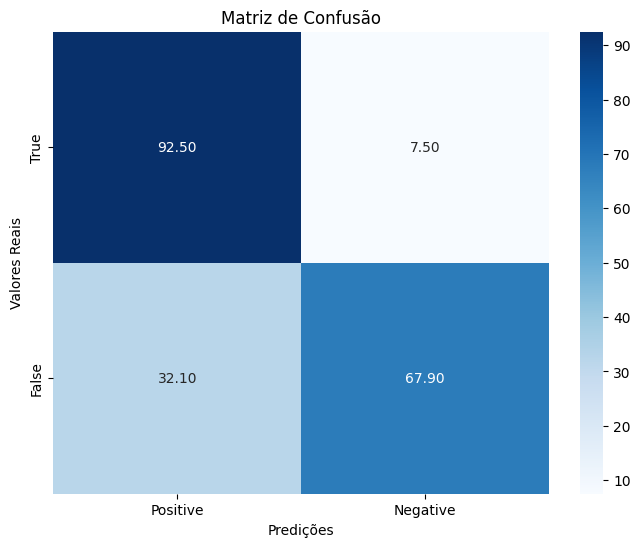

In [ ]:
cfm_train = confusion_matrix(y_treinamento, predicoes_treinamento)
rotulo2 = ['True', 'False']
rotulo1 =['Positive', 'Negative']
cfm_train_percent = (cfm_train.astype('float') / cfm_train.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cfm_train_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=rotulo1, yticklabels=rotulo2)
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

Analisando essa matriz de confusão, podemos ver alguns valores interessantes:
- True Positive: 92.50
    - Isso representa que o modelo previu corretamente que um passageiro sobreviveu em 92.50% dos casos quando ele realmente sobreviveu.
- True Negatives: 7.50
    - Representa a porcentagem de casos em que o modelo previu corretamente que o passageiro não sobreviveu.
- False Positives: 32.10
    - Porcentagem de casos que o modelo previu incorretamente que um passageiro sobreviveu quando ele na verdade não sobreviveu.
- False Negatives: 67.90
    - Representa a porcentagem de casos em que o modelo previu que o passageiro não sobreviveu quando na verdade o passageiro havia sobrevivido.

Através dessa análise, podemos perceber que o modelo nos dados de treinamento teve uma tendência muito maior a prever que o passageiro não sobrevivia, resultando em uma quantidade alta de falso negativos.

### Outras métricas(treino)

In [ ]:
print(classification_report(y_treinamento, predicoes_treinamento))

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       440
         1.0       0.85      0.68      0.75       271

    accuracy                           0.83       711
   macro avg       0.84      0.80      0.81       711
weighted avg       0.83      0.83      0.83       711



Analisando as métricas, podemos perceber o seguinte:
- O modelo possui uma precisão alta ao predizer se o passageiro sobreviveu ou não.
- O modelo possui uma precisão alta ao prever que passageiros que não sobreviveram realmente não sobreviveram, porém tem dificuldades em predizer o oposto.

### Matriz confusão (teste)



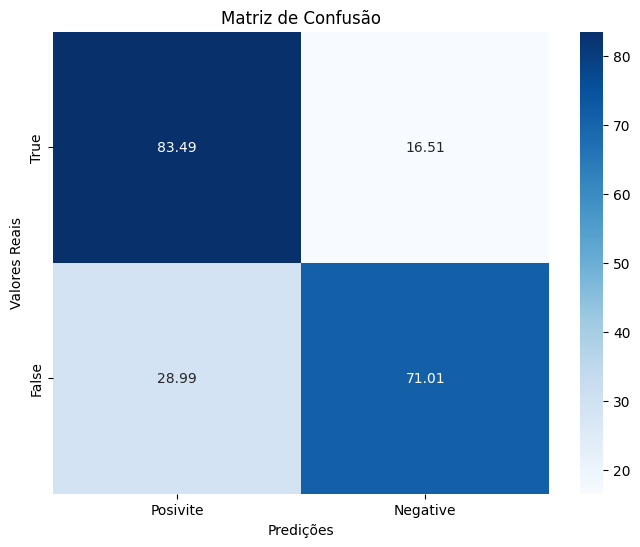

In [ ]:
cfm_train = confusion_matrix(y_teste, predicoes_teste)
rotulo2 = ['True', 'False']
rotulo1 =['Posivite', 'Negative']
cfm_train_percent = (cfm_train.astype('float') / cfm_train.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cfm_train_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=rotulo1, yticklabels=rotulo2)
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

Analisando essa matriz de confusão, podemos ver alguns valores interessantes:
- True Positive: 83.49
    - Isso representa que o modelo previu corretamente que um passageiro sobreviveu em 83.49% dos casos quando ele realmente sobreviveu.
- True Negatives: 16.51
    - Representa a porcentagem de casos em que o modelo previu corretamente que o passageiro não sobreviveu.
- False Positives: 28.99
    - Porcentagem de casos que o modelo previu incorretamente que um passageiro sobreviveu quando ele na verdade não sobreviveu.
- False Negatives: 71.01
    - Representa a porcentagem de casos em que o modelo previu que o passageiro não sobreviveu quando na verdade o passageiro havia sobrevivido.

Podemos ver que mesmo nos dados de teste, o modelo continuou com a tendência de predizer que o passageiro não sobreviveu.

### Outras métricas (teste)

In [ ]:
print(classification_report(y_teste, predicoes_teste))

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83       109
         1.0       0.73      0.71      0.72        69

    accuracy                           0.79       178
   macro avg       0.78      0.77      0.77       178
weighted avg       0.79      0.79      0.79       178



Analisando as métricas, agora em testes, podemos perceber o seguinte:
- O modelo possui uma precisão alta ao predizer se o passageiro não sobreviveu, porém a precisão diminui ao dizer se sobreviveu.
- O modelo possui uma precisão alta ao prever que passageiros que não sobreviveram realmente não sobreviveram, porém tem dificuldades em predizer o oposto, assim como no treinamento.

### K-Folds
Após isso, vamos re-treinar nosso modelo com o melhor valor de k encontrado antes (`k = 1`) e realizar a validação cruzada com 5 folds e avaliá-lo.

In [ ]:
k = 1
kf = KFold(n_splits=5, shuffle=True, random_state=42)
precisions = []

for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    fold_predictions = knn_classifier(X_train, X_test, y_train, k)
    precision = accuracy_score(y_test, fold_predictions)
    precisions.append(precision)

    print(f'Precisão do Fold {fold_idx + 1}: {precision * 100:.2f}%')

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

print(f'Precisão média com validação cruzada (5 folds): {mean_precision * 100:.2f}%')
print(f'Desvio Padrão das Precisões: {std_precision * 100:.2f}%')

Precisão do Fold 1: 78.65%
Precisão do Fold 2: 76.40%
Precisão do Fold 3: 77.53%
Precisão do Fold 4: 77.53%
Precisão do Fold 5: 77.97%
Precisão média com validação cruzada (5 folds): 77.62%
Desvio Padrão das Precisões: 0.73%


Com esse método, podemos ver que a precisão média com a validação cruzada com 5 folds ficou em 77.62% com um baixo desvio padrão das precisões.

### Testando outros valores de K utilizando validação cruzada
Então, vamos testar outros valores de `k` para descobrirmos o melhor entre eles, utilizando a média do erro.

In [ ]:
valores_k = [1, 3, 5, 7, 9]
media_erros = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in valores_k:
    precisoes = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        fold_predictions = knn_classifier(X_train, X_test, y_train, k)

        precisao = accuracy_score(y_test, fold_predictions)

        precisoes.append(precisao)

    media_erro = 1 - np.mean(precisoes)
    media_erros[k] = media_erro

for k, erro in media_erros.items():
    print(f'Valor de k: {k}, Média do Erro: {erro * 100:.2f}%')

Valor de k: 1, Média do Erro: 22.38%
Valor de k: 3, Média do Erro: 20.58%
Valor de k: 5, Média do Erro: 21.59%
Valor de k: 7, Média do Erro: 21.14%
Valor de k: 9, Média do Erro: 20.13%


Para melhor visualização, vamos fazer um gráfico.

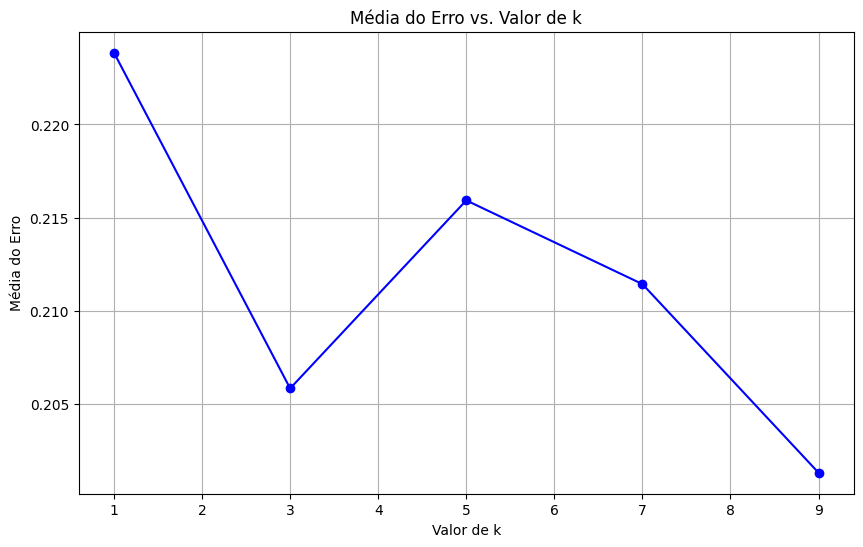

In [ ]:
valores_k = list(media_erros.keys())
erros = list(media_erros.values())

plt.figure(figsize=(10, 6))
plt.plot(valores_k, erros, marker='o', linestyle='-', color='b')
plt.title('Média do Erro vs. Valor de k')
plt.xlabel('Valor de k')
plt.ylabel('Média do Erro')
plt.grid(True)

plt.show()

Através do gráfico, podemos ver que o melhor valor de k, considerando a menor média do erro, é `k = 9`.

### Avaliação de classificadores

#### Matriz de confusão

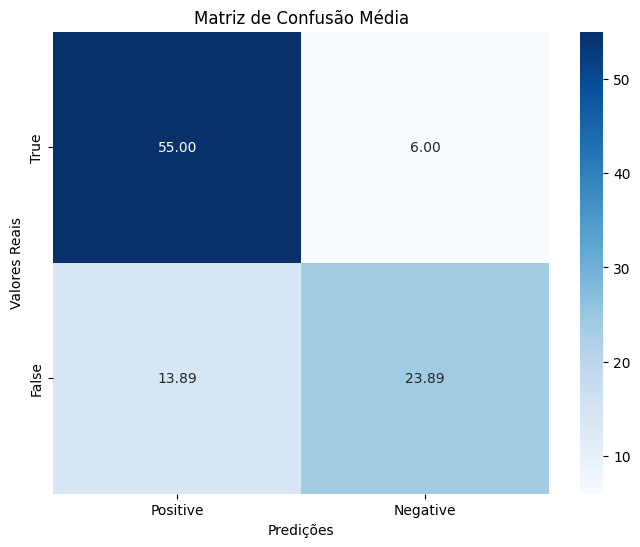

In [ ]:
k = 9
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cfm_matrices = []

for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    fold_predictions = knn_classifier(X_train, X_test, y_train, k)

    cfm_fold = confusion_matrix(y_test, fold_predictions)
    cfm_matrices.append(cfm_fold)

cfm_avg = np.mean(cfm_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(cfm_avg, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['True', 'False'])
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão Média')
plt.show()

Analisando essa matriz de confusão, podemos ver alguns valores interessantes:
- True Positive: 55
    - Isso representa que o modelo previu corretamente que um passageiro sobreviveu 55 vezes, quando ele realmente sobreviveu.
- True Negatives: 6
    - Representa o número de casos em que o modelo previu corretamente que o passageiro não sobreviveu.
- False Positives: 13.89
    - Número médio de casos que o modelo previu incorretamente que um passageiro sobreviveu quando ele na verdade não sobreviveu.
- False Negatives: 23.89
    - Representa o número médio de casos em que o modelo previu que o passageiro não sobreviveu quando na verdade o passageiro havia sobrevivido.

Através dessa análise, podemos perceber que o modelo com os folds consegui ter um valor satisfatório de previsões corretas, porém previu erroneamente nos casos em que os passageiros haviam sobrevivido ou não, principalmente quando ele sobreviveu.

#### Precisão, Cobertura, Acurácia e F1-Score

In [ ]:
k = 9
kf = KFold(n_splits=k, shuffle=True, random_state=42)

precisions = []
recalls = []
f1_scores = []
accuracies = []

for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    fold_predictions = knn_classifier(X_train, X_test, y_train, k)

    report = classification_report(y_test, fold_predictions, target_names=['Não Sobreviveu', 'Sobreviveu'], output_dict=True)

    precisions.append(report['weighted avg']['precision'])
    recalls.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])
    correct_predictions = np.sum(np.array(fold_predictions) == np.array(y_test))
    total_predictions = len(y_test)
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_accuracy = np.mean(accuracies)

print(f'Média da Precisão: {mean_precision:.2f}')
print(f'Média da Cobertura (Recall): {mean_recall:.2f}')
print(f'Média do F1-Score: {mean_f1_score:.2f}')
print(f'Média da Acurácia: {mean_accuracy:.2f}')

Média da Precisão: 0.80
Média da Cobertura (Recall): 0.80
Média do F1-Score: 0.79
Média da Acurácia: 0.80


Considerando esses resultados das métricas, podemos perceber que o modelo está correto em cerca de 80% das previsões em todos os casos.